In [35]:
from moded_eval import *

In [36]:
args.trained_model = "weights/yolact_darknet53_54_800000.pth"
args.score_threshold=0.15
args.top_k=15
if args.config is not None:
    set_cfg(args.config)

if args.trained_model == 'interrupt':
    args.trained_model = SavePath.get_interrupt('weights/')
elif args.trained_model == 'latest':
    args.trained_model = SavePath.get_latest('weights/', cfg.name)

if args.config is None:
    model_path = SavePath.from_str(args.trained_model)
    # TODO: Bad practice? Probably want to do a name lookup instead.
    args.config = model_path.model_name + '_config'
    print('Config not specified. Parsed %s from the file name.\n' % args.config)
    set_cfg(args.config)


net = Yolact()
net.load_weights(args.trained_model)
# pdb.set_trace()
net.eval()

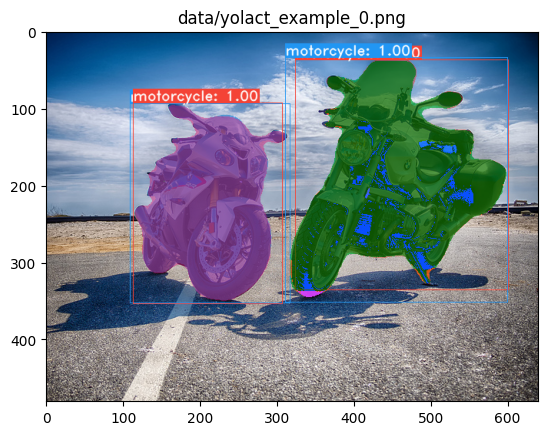

In [37]:
with torch.no_grad():
    # evaluate(net, dataset=None)
    evalimage(net, "data/yolact_example_0.png")

In [38]:
net.eval()
input_names = [ "actual_input" ]
output_names = [ "output" ]
frame = torch.from_numpy(cv2.imread("data/yolact_example_0.png")).float()
batch = FastBaseTransform()(frame.unsqueeze(0))
# net
# preds = net(batch)
# torch.onnx.export(net, batch, "yolact.onnx", opset_version=)
# torch.onnx.export(net, batch, "Yolact_Model.onnx", input_names=input_names, output_names=output_names, export_params=True)

In [39]:
import onnxruntime as onnxrt
onnx_session= onnxrt.InferenceSession("Yolact_Model.onnx")
onnx_inputs= onnx_session.get_inputs()[0].name
onnx_labels= onnx_session.get_outputs()[0].name


In [40]:
# a function to add the original classes that were in the pytorch model output
# it also converts the output to the same format to be able to use the same functions on the output
def addClasses(onnx_preds):
    converted_preds = [{'box':onnx_preds[0], 'mask':onnx_preds[1], 'class':onnx_preds[2], 'score':onnx_preds[3], 'proto':onnx_preds[4]}]
    for key, values in converted_preds[0].items():
        converted_preds[0][key] = torch.from_numpy(np.array(values))
    return converted_preds


In [41]:
def eval_onnx_image(path):
    with torch.no_grad():
        frame = torch.from_numpy(cv2.imread(path)).float()
        batch = FastBaseTransform()(frame.unsqueeze(0))
        onnx_preds = onnx_session.run(None, {onnx_inputs:batch.detach().numpy()})
        onnx_preds = addClasses(onnx_preds)
        img_numpy = prep_display(onnx_preds, frame, None, None, undo_transform=False)
        img_numpy = img_numpy[:, :, (2, 1, 0)]
        plt.imshow(img_numpy)
        plt.title(path)
        plt.show()

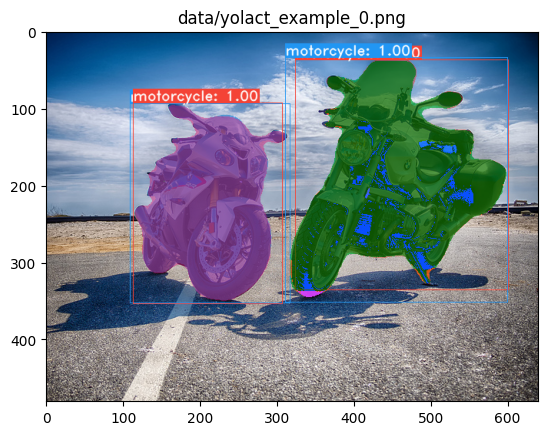

In [42]:
eval_onnx_image("data/yolact_example_0.png")

In [43]:
# mo  --input_model yolact.onnx --reverse_input_channels --scale 255

In [44]:
# import numpy as np
# from monai.transforms import LoadImage
# from openvino.runtime import Core
